#### Novelty and Outlier Detection
Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an __inlier__), or should be considered as different (it is an __outlier__). Often, this ability is used to clean real data sets. 

Two important distinctions must be made:

- outlier detection:
 	The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.
    
- novelty detection:
 	The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.
    
Outlier detection and novelty detection are both used for __anomaly detection__, where one is interested in detecting abnormal or unusual observations. Outlier detection is then also known as unsupervised anomaly detection and novelty detection as semi-supervised anomaly detection.

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

#### Parametric methods: Univariate
Create a dummy dataframe where features have normal distributions to practice parametric methods.

In [2]:
# seed for reproducibility
np.random.seed(42)

n_feats=4

dummydf = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, n_feats)),
                       columns=['feature{}'.format(i) for i in range(n_feats)])

In [8]:
dummydf.head(5)

,feature0,feature1,feature2,feature3
0,4.967142,-1.382643,6.476885,15.230299
1,-2.341534,-2.341370,15.792128,7.674347
2,-4.694744,5.425600,-4.634177,-4.657298
3,2.419623,-19.132802,-17.249178,-5.622875
4,-10.128311,3.142473,-9.080241,-14.123037


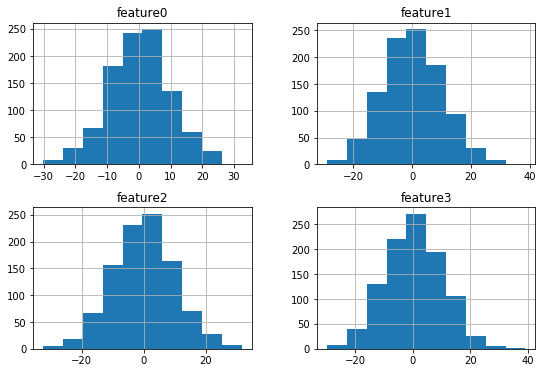

In [5]:
# all normally distributed
dummydf.hist(figsize=(9,6), xlabelsize = 10);

In [11]:
# # enough variation between features to show outliers
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


#### Define two functions that statistically identify outliers in a pandas Series using a standard deviation and interquartile range method.

In [13]:
def out_std(s, nstd=3.0, return_thresholds=False):
    
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    
    param nstd:
        Set number of standard deviations from the mean to consider an outlier
        :type nstd: ``float``
    
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
        :type return_thresholds: ``bool``
        
    """
    data_mean, data_std = s.mean(), s.std()
    
    cut_off = data_std * nstd
    
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

In [12]:
def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

__Standard Deviation:__
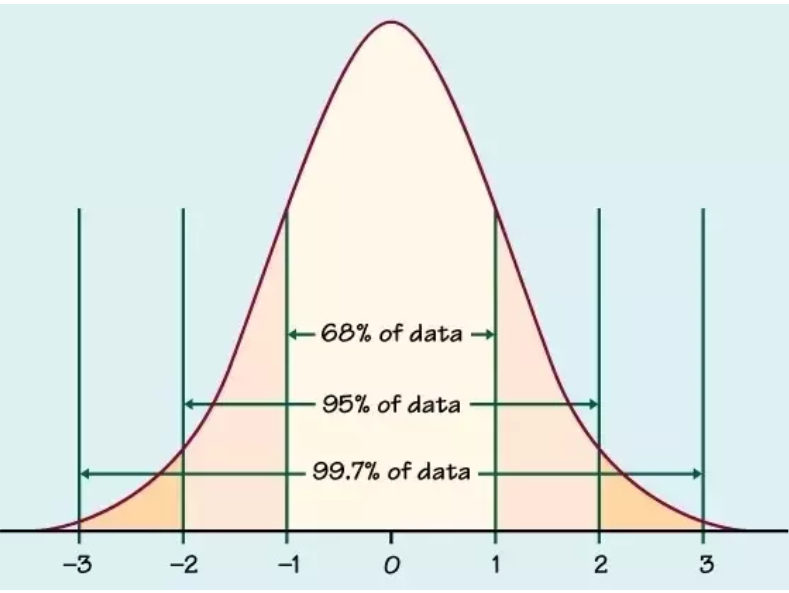

__Interquartile Range:__
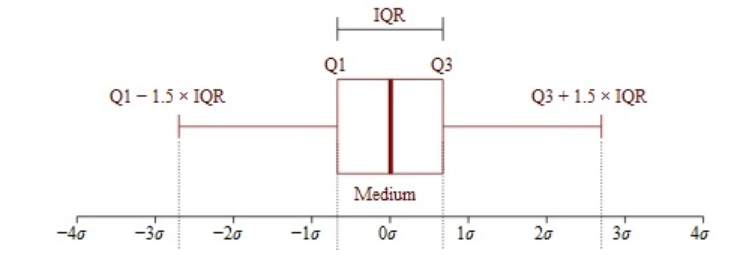

#### Standard Deviation

In [17]:
# outlier_mask is a boolean list identifies the indices of the outliers
outlier_mask = out_std(dummydf['feature0'], nstd=3.0)

# first 10 elements
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

In [27]:
# get all the outlier data
dummydf['feature0'][outlier_mask]

506   -30.195122
788   -29.069882
929    32.430930
Name: feature0, dtype: float64

In [24]:
# find all the index positions where it is TRUE (outlier)
for i in outlier_mask:
    if i == True:
        print(i)

True
True
True


In [22]:
# python list gets the first index
outlier_mask.index(True)

506

In [25]:
# convert the outlier_mask to numpy array
np_outlier_mask = np.array(outlier_mask)

np.where(np_outlier_mask == True)

(array([506, 788, 929], dtype=int64),)

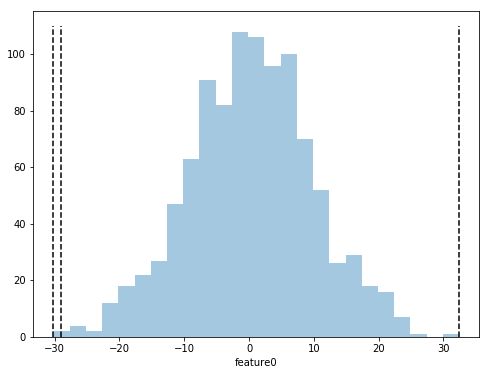

In [28]:
plt.figure(figsize=(8,6))
sns.distplot(dummydf['feature0'], kde=False);
plt.vlines(dummydf['feature0'][outlier_mask], ymin=0, ymax=110, linestyles='dashed');

#### Example 2

In [35]:
arr = [10, 386, 479, 627, 20, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 763, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543]

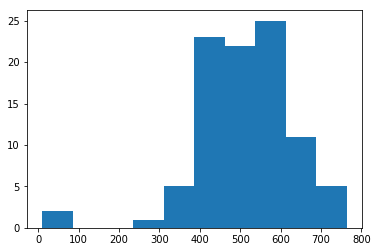

In [42]:
plt.hist(arr);

In [37]:
elements = np.array(arr)

In [38]:
mean = np.mean(elements, axis=0)
sd   = np.std(elements, axis=0)

In [39]:
final_list = [x for x in arr        if (x > mean - 2 * sd)]
print(final_list)

[386, 479, 627, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 763, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543]


In [40]:
final_list = [x for x in final_list if (x < mean + 2 * sd)]
print(final_list)

[386, 479, 627, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543]


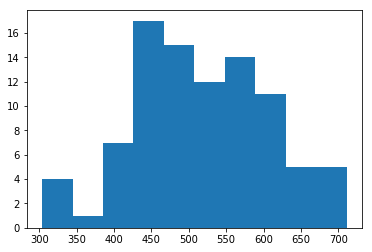

In [43]:
plt.hist(final_list);